In [2247]:
#Data Loading and Initial Exploration

In [2248]:
pip install pretty_midi

Note: you may need to restart the kernel to use updated packages.


In [2249]:
import os
from os import path
import h5py
import pandas as pd
import json
import shutil
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# paths
hdf5_folder = "/Users/vnissankara/Downloads/lmd_matched_h5/"  
midi_folder = "/Users/vnissankara/Downloads/lmd_matched/"   
match_scores_path = "/Users/vnissankara/Downloads/match_scores.json"  


out_csv = "/Users/vnissankara/Downloads/lakh_metadata.csv"   
out_midi = "/Users/vnissankara/Downloads/lmd_subset/" 

# Ensure the output MIDI directory exists
os.makedirs(out_midi, exist_ok=True) 

# Load Match Scores JSON
with open(match_scores_path, "r") as json_file:
    scores = json.load(json_file)

# Data Extraction and Preprocessing (HDF5 and MIDI)
def read_hdf5(file_path):
    try:
        # Extract MSD ID
        id = file_path.replace(hdf5_folder, "").replace(".h5", "")
        msd_id = id.split("/")[-1]
        item = {"id": msd_id}

        with h5py.File(file_path, "r") as f:
            # Metadata Extraction
            item["year"] = f["musicbrainz/songs"][0][1]

            tags_echo = f["metadata/artist_terms"][:] 
            item["tag_echo"] = tags_echo[0].decode() if len(tags_echo) > 0 else ""

            tags_mbz = f["musicbrainz/artist_mbtags"][:]
            item["tag_mbz"] = tags_mbz[0].decode() if len(tags_mbz) > 0 else ""

            song = f["metadata/songs"][0]
            item["artist_mb"] = song[8].decode() if song[8] else ""
            item["artist_name"] = song[9].decode() if song[9] else ""
            item["album_name"] = song[14].decode() if song[14] else ""
            item["song_name"] = song[18].decode() if song[18] else ""

            # Find and copy the best matching MIDI file
            candidates = scores.get(msd_id, {})
            best = max(candidates, key=candidates.get, default=None)

            if best:
                midi_file = path.join(midi_folder, id, best + ".mid")
                if path.exists(midi_file):
                    output_file = path.join(out_midi, msd_id + ".mid")
                    shutil.copyfile(midi_file, output_file)
                    item["file"] = output_file
                else:
                    item["file"] = None
                    print(f"Missing MIDI file for {msd_id}")
            else:
                item["file"] = None
                print(f"No match found for {msd_id}")

        return item
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Process all HDF5 files
records = []
file_list = [
    path.join(root, name)
    for root, _, files in os.walk(hdf5_folder) 
    for name in files
    if name.endswith(".h5")
]

for f in tqdm(file_list, desc="Processing HDF5 files"):
    result = read_hdf5(f)
    if result:
        records.append(result)

# save metadata to CSV
df = pd.DataFrame(records)
df.to_csv(out_csv, index=False)
print(f"Metadata saved to {out_csv}")


Processing HDF5 files: 100%|█████████████| 31034/31034 [00:53<00:00, 575.55it/s]


Metadata saved to /Users/vnissankara/Downloads/lakh_metadata.csv


In [2250]:
#Exploratory Data Analysis 

In [2251]:
df = pd.read_csv("/Users/vnissankara/Downloads/lakh_metadata.csv")

In [2252]:
df

,id,year,tag_echo,tag_mbz,artist_mb,artist_name,album_name,song_name,file
0,TRRRUFD12903CD7092,1994,space rock,british,5a28f8c2-31fb-4047-ae57-c5c326989262,Hawkwind,Alien 4,Wastelands,/Users/vnissankara/Downloads/lmd_subset/TRRRUF...
1,TRRRUTV12903CEA11B,1961,ballad,classic pop and rock,2e885bfb-1f59-49cf-8d51-e743445e1b48,Del Shannon,Songs of Del Shannon,Runaway,/Users/vnissankara/Downloads/lmd_subset/TRRRUT...
2,TRRRUJO128E07813E7,2001,british pop,pop,db4624cf-0e44-481e-a9dc-2142b833ec2f,Robbie Williams,Swing When You're Winning,Have You Met Miss Jones? (Swing When Version),/Users/vnissankara/Downloads/lmd_subset/TRRRUJ...
3,TRRRIYO128F428CF6F,0,alternative country,NaN,eb567c55-368d-4b85-b969-ca9e3252f9cb,Volebeats,Bittersweet,Goodbye,/Users/vnissankara/Downloads/lmd_subset/TRRRIY...
4,TRRRILO128F422FFED,1997,cumbia,NaN,ead8d6d9-e58b-4dd8-916f-cf7f359db38e,Rodolfo Y Su Tipica Ra7,Musica Tropical De Colombia 5,La Colegiala,/Users/vnissankara/Downloads/lmd_subset/TRRRIL...
...,...,...,...,...,...,...,...,...,...
31029,TRWWYHD12903CC42B1,0,opera,NaN,2c654643-cdbd-4634-be26-c4d1a90cfabd,Michael Crawford,In Concert,Gethsemane (I Only Want to Say) (Live-LP Version),/Users/vnissankara/Downloads/lmd_subset/TRWWYH...
31030,TRWWYNJ128F426541F,1992,hard rock,punk,e1e05cce-3922-44e1-8f20-015abe5e309d,Social Distortion,Somewhere Between Heaven And Hell,Cold Feelings,/Users/vnissankara/Downloads/lmd_subset/TRWWYN...
31031,TRWWPSV128F4244C71,2001,power metal,NaN,17828264-0f4a-40b3-bfc5-8544f30debed,At Vance,Dragonchaser,Ases Death,/Users/vnissankara/Downloads/lmd_subset/TRWWPS...
31032,TRWWPBK128F42911E9,1993,progressive metal,finnish,efaefde1-e09b-4d49-9d8e-b1304d2ece8d,Amorphis,Chapters,Drowned Maid,/Users/vnissankara/Downloads/lmd_subset/TRWWPB...


In [2253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31034 entries, 0 to 31033
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           31034 non-null  object
 1   year         31034 non-null  int64 
 2   tag_echo     30708 non-null  object
 3   tag_mbz      14391 non-null  object
 4   artist_mb    29049 non-null  object
 5   artist_name  31034 non-null  object
 6   album_name   31034 non-null  object
 7   song_name    31034 non-null  object
 8   file         31034 non-null  object
dtypes: int64(1), object(8)
memory usage: 2.1+ MB


In [2254]:
missing_data = df.isnull().sum()
print("\nMissing Data:")
print(missing_data)


Missing Data:
id                 0
year               0
tag_echo         326
tag_mbz        16643
artist_mb       1985
artist_name        0
album_name         0
song_name          0
file               0
dtype: int64


In [2255]:
df['tag_mbz'].nunique()

484


Genre Counts:
tag_mbz
classic pop and rock    1396
uk                       996
british                  835
rock and indie           586
american                 503
                        ... 
france                     1
bajofondo                  1
partiendome el alma        1
massachusetts              1
desi                       1
Name: count, Length: 484, dtype: int64


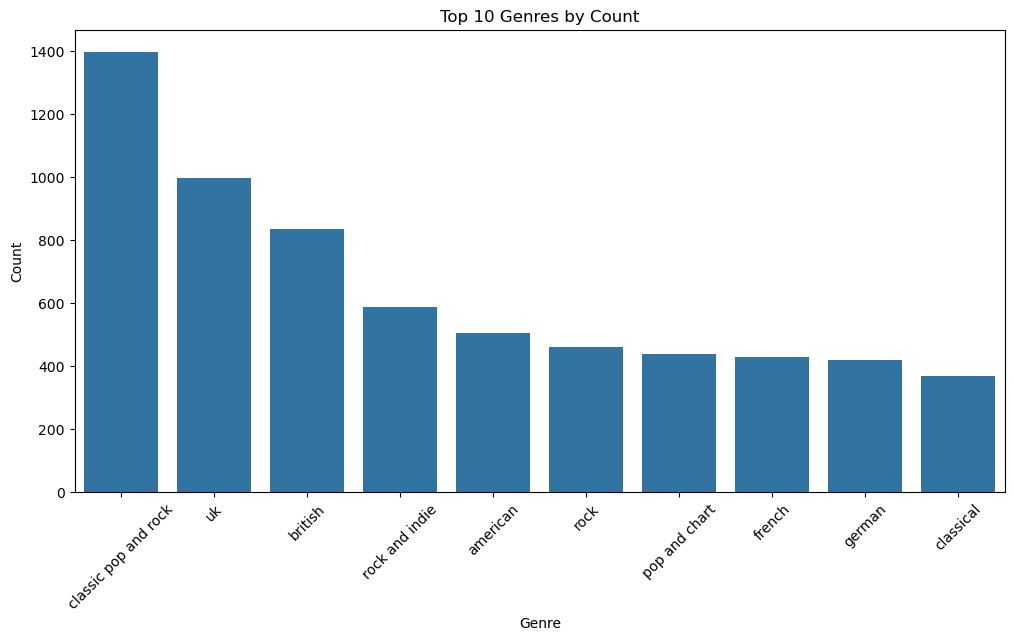

In [2256]:
if 'tag_mbz' in df.columns:
    genre_counts = df['tag_mbz'].value_counts()
    print("\nGenre Counts:")
    print(genre_counts)

    # Plot genre distribution
    plt.figure(figsize=(12, 6))
    sns.barplot(x=genre_counts.index[:10], y=genre_counts.values[:10])
    plt.title("Top 10 Genres by Count")
    plt.xlabel("Genre")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

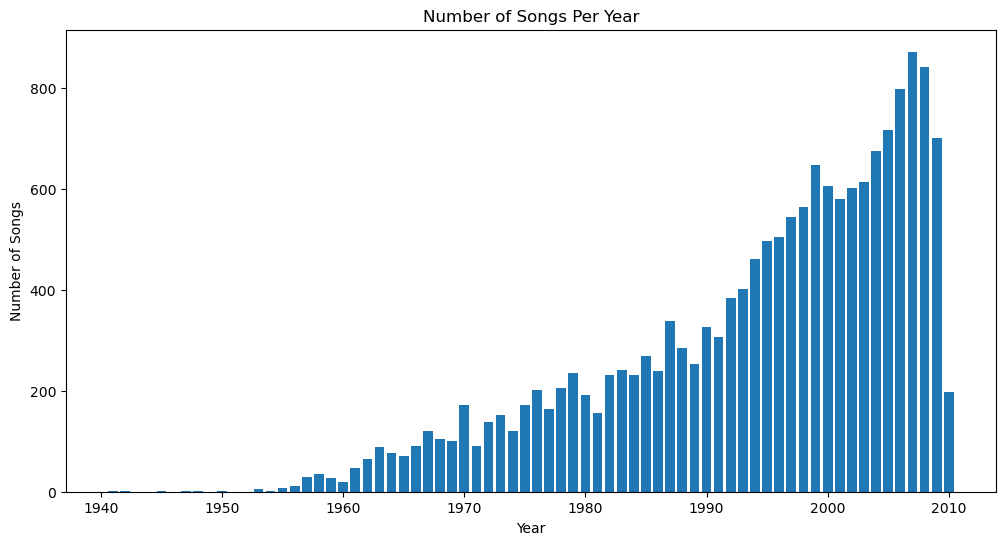

In [2257]:
# Songs per year
df['year'] = df['year'].astype(int)
yearly_counts = df[df['year'] > 0]['year'].value_counts().sort_index()

# Plot songs per year
plt.figure(figsize=(12, 6))
plt.bar(yearly_counts.index, yearly_counts.values)
plt.title("Number of Songs Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Songs")
plt.show()


In [2258]:
#Data Cleaning and Filtering

In [2259]:
# Remove rows with missing 'tag_mbz'
df_filtered = df.dropna(subset=['tag_mbz'])

In [2260]:
# Columns to keep
columns_to_keep = ['file', 'year', 'tag_mbz', 'tag_echo']  
df_filtered = df_filtered[columns_to_keep]
df_filtered

,file,year,tag_mbz,tag_echo
0,/Users/vnissankara/Downloads/lmd_subset/TRRRUF...,1994,british,space rock
1,/Users/vnissankara/Downloads/lmd_subset/TRRRUT...,1961,classic pop and rock,ballad
2,/Users/vnissankara/Downloads/lmd_subset/TRRRUJ...,2001,pop,british pop
5,/Users/vnissankara/Downloads/lmd_subset/TRRRIV...,1978,soft rock,soft rock
8,/Users/vnissankara/Downloads/lmd_subset/TRRRNP...,0,classical,orchestra
...,...,...,...,...
31025,/Users/vnissankara/Downloads/lmd_subset/TRWWLL...,2002,alternative rock,post-grunge
31026,/Users/vnissankara/Downloads/lmd_subset/TRWWLU...,2004,american idol,teen pop
31028,/Users/vnissankara/Downloads/lmd_subset/TRWWYU...,1995,german,industrial metal
31030,/Users/vnissankara/Downloads/lmd_subset/TRWWYN...,1992,punk,hard rock


In [2261]:
# Save the filtered dataset
filtered_file_path = "/Users/vnissankara/Downloads/lakh_metadata_filtered.csv"
df_filtered.to_csv(filtered_file_path, index=False)

df_filtered_shape = df_filtered.shape
filtered_file_path, df_filtered_shape

('/Users/vnissankara/Downloads/lakh_metadata_filtered.csv', (14391, 4))

In [2262]:
df1 = pd.read_csv("/Users/vnissankara/Downloads/lakh_metadata_filtered.csv")

In [2263]:
df1.head() 

,file,year,tag_mbz,tag_echo
0,/Users/vnissankara/Downloads/lmd_subset/TRRRUF...,1994,british,space rock
1,/Users/vnissankara/Downloads/lmd_subset/TRRRUT...,1961,classic pop and rock,ballad
2,/Users/vnissankara/Downloads/lmd_subset/TRRRUJ...,2001,pop,british pop
3,/Users/vnissankara/Downloads/lmd_subset/TRRRIV...,1978,soft rock,soft rock
4,/Users/vnissankara/Downloads/lmd_subset/TRRRNP...,0,classical,orchestra


In [2264]:
#Feature Extraction
#MIDI data is unstructured; converting it into meaningful numerical features is essential for model training

In [2265]:
def extract_chords(midi_data):
    """
    Extract and count chord progressions from MIDI data.
    A chord is a group of notes starting at the same time.
    """
    chords = []
    for instrument in midi_data.instruments:
        if not instrument.is_drum:  # Skip percussion tracks
            chord_notes = {}
            for note in instrument.notes:
                start_time = round(note.start, 2) 
                if start_time not in chord_notes:
                    chord_notes[start_time] = []
                chord_notes[start_time].append(note.pitch)
            
            for chord in chord_notes.values():
                if len(chord) > 1:  
                    chords.append(tuple(sorted(chord)))  
    return len(set(chords))
def extract_rhythm_features(midi_data):
    """
    Extract rhythm features such as tempo variance and beat count.
    """
    try:
        # Extract tempo changes
        tempos = midi_data.get_tempo_changes()[1]
        tempo_variance = np.var(tempos) if len(tempos) > 0 else 0

        # Extract beats
        beats = midi_data.get_beats()
        beat_count = len(beats)

        return tempo_variance, beat_count
    except Exception as e:
        print(f"Error extracting rhythm features: {e}")
        return 0,0
def extract_timbre_features(midi_data):
    """
    Extract timbre features such as velocity statistics and instrument diversity.
    """
    try:
        # Velocity statistics
        velocities = [note.velocity for instrument in midi_data.instruments for note in instrument.notes]
        avg_velocity = np.mean(velocities) if len(velocities) > 0 else 0

        # Instrument diversity
        instrument_diversity = len(set(instr.name for instr in midi_data.instruments if instr.name))

        return avg_velocity, instrument_diversity
    except Exception as e:
        print(f"Error extracting timbre features: {e}")
        return 0, 0
        
def extract_harmonic_features(midi_data):
    """
    Extract harmonic features such as chord transitions and key changes.
    """
    try:
        # Chord transition diversity
        num_chords = extract_chords(midi_data)

        # Key signature changes
        key_changes = len(midi_data.key_signature_changes)

        return num_chords, key_changes
    except Exception as e:
        print(f"Error extracting harmonic features: {e}")
        return 0, 0

def extract_features(file_path):
    """
    Extracts various audio features from a MIDI file using PrettyMIDI.
    """
    try:
        midi_data = pretty_midi.PrettyMIDI(file_path)
        
        # Tempo: Average tempo in beats per minute
        tempos = midi_data.get_tempo_changes()[1] 
        avg_tempo = np.mean(tempos) if len(tempos) > 0 else 0
        
        # Duration: Total duration of the song in seconds
        duration = midi_data.get_end_time()  
        
        # Pitch: Average and variance of all note pitches
        pitches = [note.pitch for instrument in midi_data.instruments for note in instrument.notes]
        avg_pitch = np.mean(pitches) if len(pitches) > 0 else 0
        pitch_range = max(pitches) - min(pitches) if len(pitches) > 0 else 0
                
        # Number of Instruments
        num_instruments = len(midi_data.instruments)
    
        # Chord Progressions
        num_chords = extract_chords(midi_data)  # Use the custom chord detection function

        #rhythm features
        tempo_variance, beat_count = extract_rhythm_features(midi_data)

        # timbre features
        avg_velocity,  instrument_diversity = extract_timbre_features(midi_data)

        # harmonic features
        num_chords, key_changes = extract_harmonic_features(midi_data)
        
        
        # Return all extracted features as a list
        return [
            avg_tempo, avg_pitch,pitch_range, duration,
            num_instruments, num_chords,
            tempo_variance, beat_count,
            avg_velocity, instrument_diversity,
            key_changes]
    
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None



In [2266]:
valid_features = []
error_files = []

# Feature extraction loop
for _, row in df_filtered.iterrows():
    midi_file = row['file']
    genre = row['tag_mbz']
    
    if os.path.exists(midi_file):
        try:
            # Try extracting features
            features = extract_features(midi_file)
            if features:  # Check if features were successfully extracted
                features.append(genre)  
                features.insert(0, midi_file)  # Include the file path for traceability
                valid_features.append(features)  
            else:
                error_files.append((midi_file, "Feature extraction failed"))
        except Exception as e:
            
            error_files.append((midi_file, str(e)))
    else:
        error_files.append((midi_file, "File does not exist"))

# Save valid features
if valid_features:
    columns = ['File','avg_tempo', 'avg_pitch','pitch_range', 'duration',
            'num_instruments', 'num_chords',
            'tempo_variance', 'beat_count',
            'avg_velocity', 'instrument_diversity',
            'key_changes' ,'Genre'
    ]
    features_df = pd.DataFrame(valid_features, columns=columns)
    
    features_file_path = "/Users/vnissankara/Downloads/midi_features_valid.csv"
    features_df.to_csv(features_file_path, index=False)
    print(f"Features extracted successfully! Saved to: {features_file_path}")
else:
    print("No valid features were extracted. Output CSV not created.")

# Save error log to CSV
if error_files:
    error_log_path = "/Users/vnissankara/Downloads/midi_error_log.csv"
    pd.DataFrame(error_files, columns=['File', 'Error']).to_csv(error_log_path, index=False)
    print(f"Error log saved to: {error_log_path}")
else:
    print("No errors encountered. Error log not created.")

/opt/anaconda3/lib/python3.12/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error processing file /Users/vnissankara/Downloads/lmd_subset/TRRUIKN128E078218F.mid: data byte must be in range 0..127
Error processing file /Users/vnissankara/Downloads/lmd_subset/TRRGEJM128F1480E86.mid: data byte must be in range 0..127
Error processing file /Users/vnissankara/Downloads/lmd_subset/TRRHZML128F92FDE10.mid: data byte must be in range 0..127
Error processing file /Users/vnissankara/Downloads/lmd_subset/TRRXSEK128E078F6C7.mid: data byte must be in range 0..127
Error processing file /Users/vnissankara/Downloads/lmd_subset/TRRKSJO128F4274499.mid: data byte must be in range 0..127
Error processing file /Users/vnissankara/Downloads/lmd_subset/TRRKFEP128F42AD604.mid: 
Error processing file /Users/vnissankara/Downloads/lmd_subset/TRRLVUI128F932ACC8.mid: data byte must be in range 0..127
Error processing file /Users/vnissankara/Downloads/lmd_subset/TRUROLZ12903CE3A8D.mid: Could not decode key with 1 flats and mode 255
Error processing file /Users/vnissankara/Downloads/lmd_subse

In [2267]:
valid_file = pd.read_csv("/Users/vnissankara/Downloads/midi_features_valid.csv")

In [2268]:
valid_file

,File,avg_tempo,avg_pitch,pitch_range,duration,num_instruments,num_chords,tempo_variance,beat_count,avg_velocity,instrument_diversity,key_changes,Genre
0,/Users/vnissankara/Downloads/lmd_subset/TRRRUF...,86.000052,71.599537,55,158.651068,3,9,0.000000,228,126.804398,3,1,british
1,/Users/vnissankara/Downloads/lmd_subset/TRRRUT...,151.000378,60.187927,60,141.733917,9,83,0.000000,357,104.967510,9,0,classic pop and rock
2,/Users/vnissankara/Downloads/lmd_subset/TRRRUJ...,122.000069,56.108982,57,153.319585,11,176,0.000000,312,92.086997,0,0,pop
3,/Users/vnissankara/Downloads/lmd_subset/TRRRIV...,76.999978,59.036687,58,177.662388,7,185,0.000000,228,73.717095,7,1,soft rock
4,/Users/vnissankara/Downloads/lmd_subset/TRRRNP...,80.000000,61.032824,57,291.750000,11,108,0.000000,389,95.053763,1,0,classical
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14252,/Users/vnissankara/Downloads/lmd_subset/TRWWLL...,145.000036,50.907701,53,225.103392,6,48,0.000000,545,94.962061,0,1,alternative rock
14253,/Users/vnissankara/Downloads/lmd_subset/TRWWLU...,132.000132,45.388762,56,184.014968,8,36,0.000000,405,110.000000,8,0,american idol
14254,/Users/vnissankara/Downloads/lmd_subset/TRWWYU...,70.000070,49.524439,53,281.142576,8,9,0.000000,328,65.880418,0,0,german
14255,/Users/vnissankara/Downloads/lmd_subset/TRWWYN...,167.500036,45.912219,50,142.757084,5,8,56.250547,417,94.777384,4,0,punk


In [2269]:
#Feature  Normalization
#Ensures that features with larger numerical ranges do not dominate the learning process

In [2270]:
from sklearn.preprocessing import MinMaxScaler

numeric_columns = [
        'avg_tempo', 'avg_pitch','pitch_range', 'duration',
            'num_instruments', 'num_chords',
            'tempo_variance', 'beat_count',
            'avg_velocity', 'instrument_diversity',
            'key_changes'
    ]
scaler = MinMaxScaler()

# Normalize the numerical columns
valid_file[numeric_columns] = scaler.fit_transform(valid_file[numeric_columns])

In [2271]:
# Remove country names from genres
countries_to_remove = ['uk', 'british', 'american', 'french', 'german', 'italian', 'canadian']
pattern = '|'.join(countries_to_remove)

# Filter the DataFrame to exclude rows where the 'Genre' column contains any of the country names
valid_file = valid_file[~valid_file['Genre'].str.contains(pattern, case=False, na=False)]

In [2272]:
file_path = "/Users/vnissankara/Downloads/normalized_file.csv" 
valid_file.to_csv(file_path, index=False)

print(f"Normalized file saved to: {file_path}")


Normalized file saved to: /Users/vnissankara/Downloads/normalized_file.csv


In [2273]:
n_file = pd.read_csv("/Users/vnissankara/Downloads/normalized_file.csv")

In [2274]:
n_file

,File,avg_tempo,avg_pitch,pitch_range,duration,num_instruments,num_chords,tempo_variance,beat_count,avg_velocity,instrument_diversity,key_changes,Genre
0,/Users/vnissankara/Downloads/lmd_subset/TRRRUT...,0.332042,0.455617,0.417391,0.005694,0.119403,0.113699,0.000000,0.008462,0.783995,0.28125,0.000000,classic pop and rock
1,/Users/vnissankara/Downloads/lmd_subset/TRRRUJ...,0.257106,0.392739,0.391304,0.006284,0.149254,0.241096,0.000000,0.007336,0.657716,0.00000,0.000000,pop
2,/Users/vnissankara/Downloads/lmd_subset/TRRRIV...,0.140827,0.437870,0.400000,0.007525,0.089552,0.253425,0.000000,0.005233,0.477619,0.21875,0.005181,soft rock
3,/Users/vnissankara/Downloads/lmd_subset/TRRRNP...,0.148579,0.468641,0.391304,0.013339,0.149254,0.147945,0.000000,0.009264,0.686802,0.03125,0.000000,classical
4,/Users/vnissankara/Downloads/lmd_subset/TRRRNK...,0.096899,0.417142,0.434783,0.009373,0.059701,0.060274,0.000000,0.004882,0.548047,0.00000,0.000000,rock and indie
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10521,/Users/vnissankara/Downloads/lmd_subset/TRWWEX...,0.195090,0.446916,0.452174,0.014883,0.223881,0.080822,0.004175,0.009764,0.686859,0.00000,0.005181,pop and chart
10522,/Users/vnissankara/Downloads/lmd_subset/TRWWBR...,0.285536,0.319938,0.721739,0.009418,0.149254,0.068493,0.000000,0.011467,0.742925,0.31250,0.000000,rock
10523,/Users/vnissankara/Downloads/lmd_subset/TRWWLL...,0.316538,0.312560,0.356522,0.009943,0.074627,0.065753,0.000000,0.013169,0.685903,0.00000,0.005181,alternative rock
10524,/Users/vnissankara/Downloads/lmd_subset/TRWWYN...,0.374677,0.235554,0.330435,0.005746,0.059701,0.010959,0.000485,0.009965,0.684092,0.12500,0.000000,punk


In [2275]:
n_file['Genre'].nunique()

467

In [2276]:
#Data Filtering

In [2277]:
# Filter genres with more than 200 instances
valid_genres = genre_counts[genre_counts > 200].index

# Create a filtered DataFrame
df_filtered_genres = n_file[n_file['Genre'].isin(valid_genres)]

print(f"Filtered dataset contains {len(df_filtered_genres)} rows.")
print(df_filtered_genres['Genre'].value_counts())


Filtered dataset contains 4637 rows.
Genre
classic pop and rock          1376
rock and indie                 582
rock                           451
pop and chart                  434
classical                      368
country                        344
folk                           310
pop                            284
hip hop rnb and dance hall     270
alternative rock               218
Name: count, dtype: int64


In [2278]:
# Save the filtered dataset
filtered_features_path = "/Users/vnissankara/Downloads/midi_features_final_filtered.csv"
df_filtered_genres.to_csv(filtered_features_path, index=False)
print(f"Filtered dataset saved to: {filtered_features_path}")

Filtered dataset saved to: /Users/vnissankara/Downloads/midi_features_final_filtered.csv


In [2279]:
final_filtered = pd.read_csv("/Users/vnissankara/Downloads/midi_features_final_filtered.csv")

In [2280]:
final_filtered.head()

,File,avg_tempo,avg_pitch,pitch_range,duration,num_instruments,num_chords,tempo_variance,beat_count,avg_velocity,instrument_diversity,key_changes,Genre
0,/Users/vnissankara/Downloads/lmd_subset/TRRRUT...,0.332042,0.455617,0.417391,0.005694,0.119403,0.113699,0.000000,0.008462,0.783995,0.28125,0.000000,classic pop and rock
1,/Users/vnissankara/Downloads/lmd_subset/TRRRUJ...,0.257106,0.392739,0.391304,0.006284,0.149254,0.241096,0.000000,0.007336,0.657716,0.00000,0.000000,pop
2,/Users/vnissankara/Downloads/lmd_subset/TRRRNP...,0.148579,0.468641,0.391304,0.013339,0.149254,0.147945,0.000000,0.009264,0.686802,0.03125,0.000000,classical
3,/Users/vnissankara/Downloads/lmd_subset/TRRRNK...,0.096899,0.417142,0.434783,0.009373,0.059701,0.060274,0.000000,0.004882,0.548047,0.00000,0.000000,rock and indie
4,/Users/vnissankara/Downloads/lmd_subset/TRRRZX...,0.188630,0.440170,0.373913,0.007356,0.044776,0.020548,0.000175,0.006810,0.735294,0.00000,0.005181,classic pop and rock


In [2281]:
final_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4637 entries, 0 to 4636
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   File                  4637 non-null   object 
 1   avg_tempo             4637 non-null   float64
 2   avg_pitch             4637 non-null   float64
 3   pitch_range           4637 non-null   float64
 4   duration              4637 non-null   float64
 5   num_instruments       4637 non-null   float64
 6   num_chords            4637 non-null   float64
 7   tempo_variance        4637 non-null   float64
 8   beat_count            4637 non-null   float64
 9   avg_velocity          4637 non-null   float64
 10  instrument_diversity  4637 non-null   float64
 11  key_changes           4637 non-null   float64
 12  Genre                 4637 non-null   object 
dtypes: float64(11), object(2)
memory usage: 471.1+ KB


In [2282]:
#Data Visualization

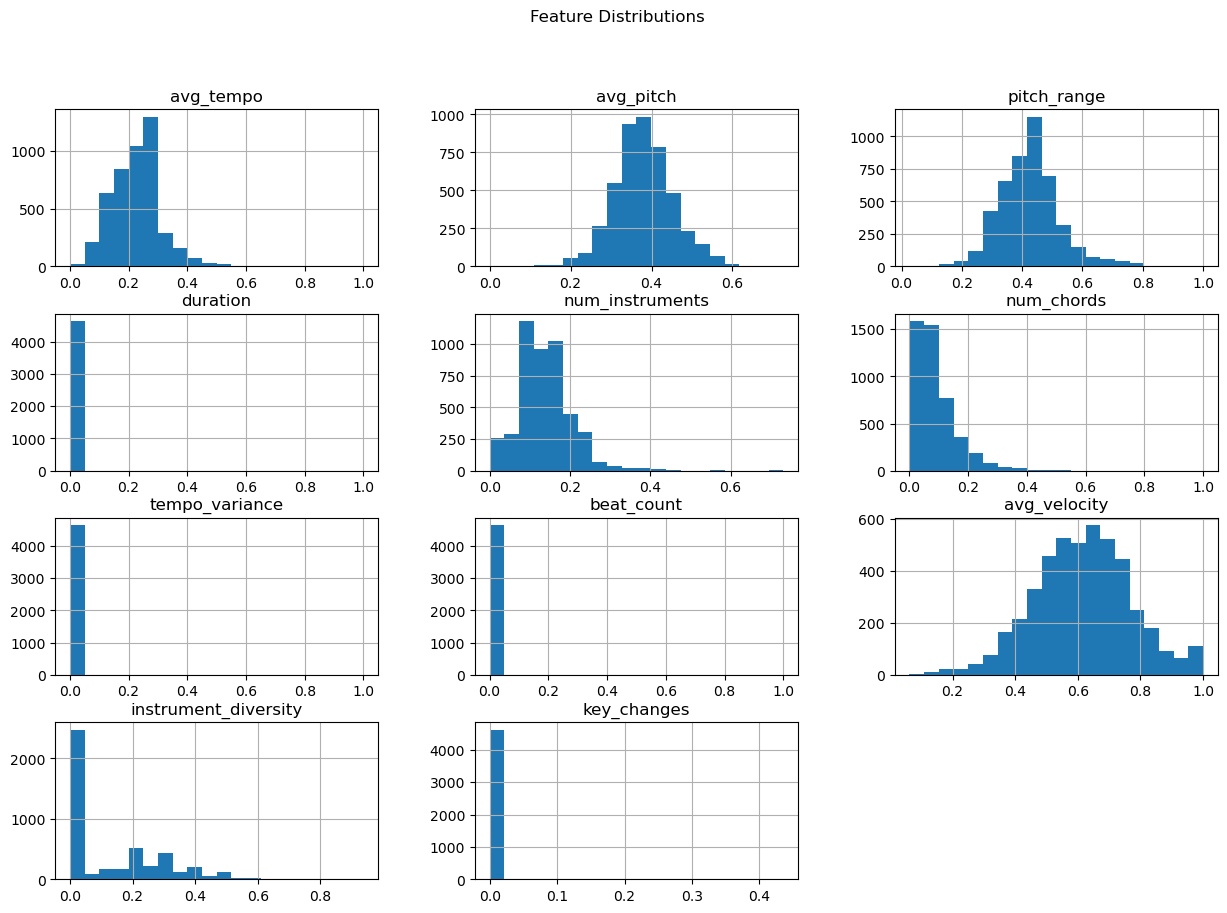

In [2283]:
# Plot distribution of numerical features
columns = [
        'File','avg_tempo', 'avg_pitch','pitch_range', 'duration',
            'num_instruments', 'num_chords',
            'tempo_variance', 'beat_count',
            'avg_velocity', 'instrument_diversity',
            'key_changes' ,'Genre'
    ]

final_filtered[numeric_columns].hist(bins=20, figsize=(15, 10))
plt.suptitle("Feature Distributions")
plt.show()


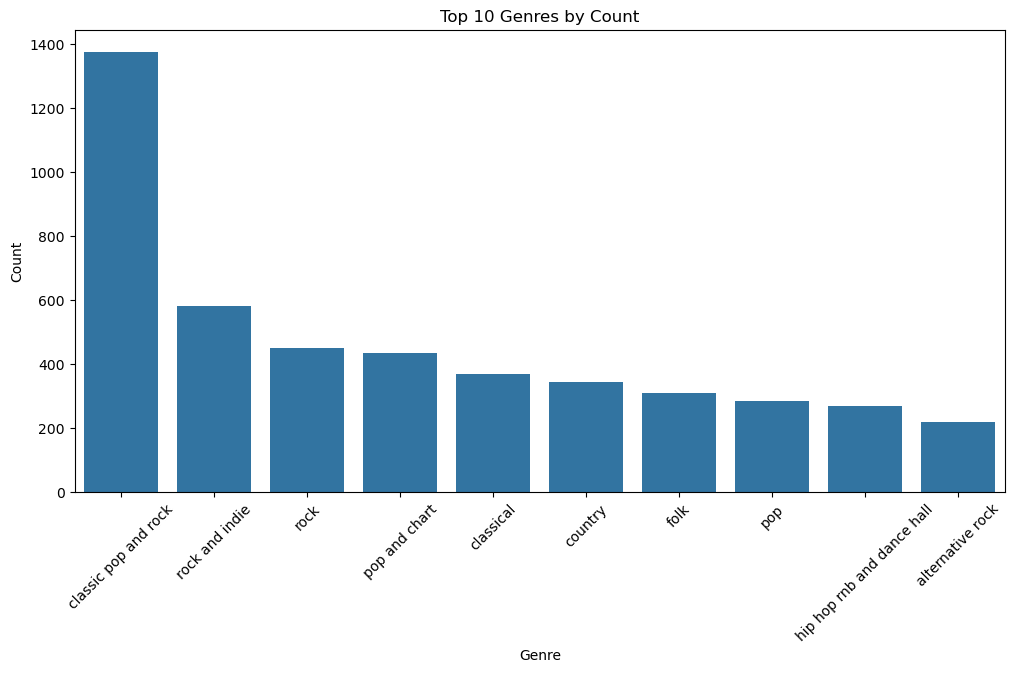

In [2284]:
# Genre distribution
genre_counts = final_filtered['Genre'].value_counts()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index[:10], y=genre_counts.values[:10])
plt.xticks(rotation=45)
plt.title("Top 10 Genres by Count")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()


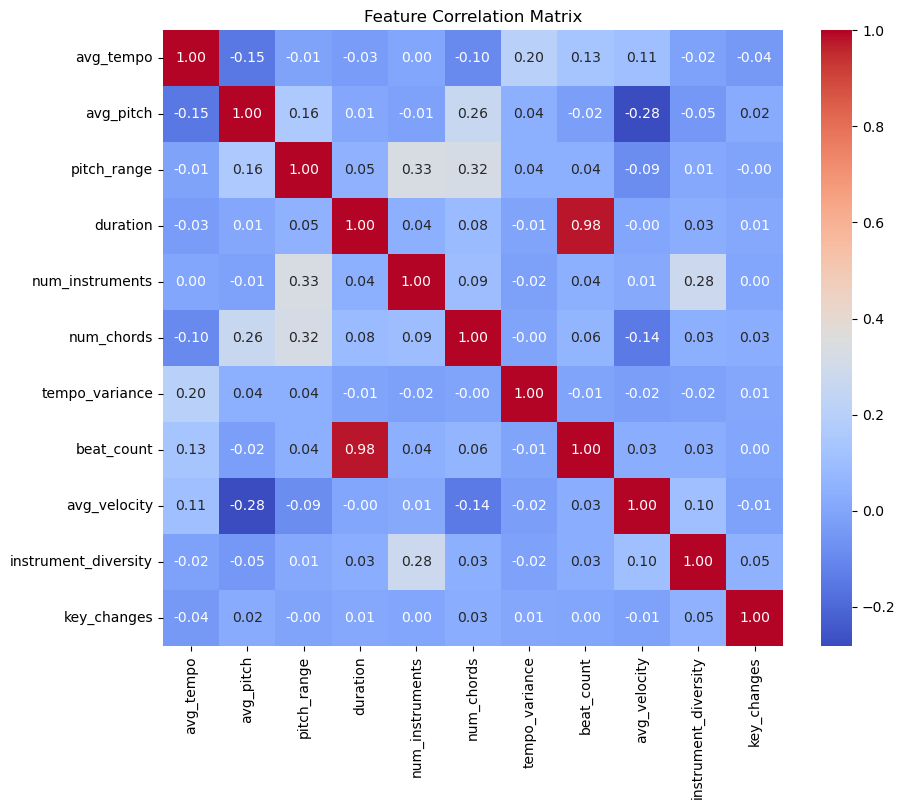

In [2285]:
# Compute correlation matrix
correlation_matrix = final_filtered.iloc[:, 1:-1].corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

/var/folders/w9/x_vp270x1kjf9vjzyjp15q5h0000gp/T/ipykernel_68179/659727091.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=genre_pitch_means.index, y=genre_pitch_means.values, palette="viridis")


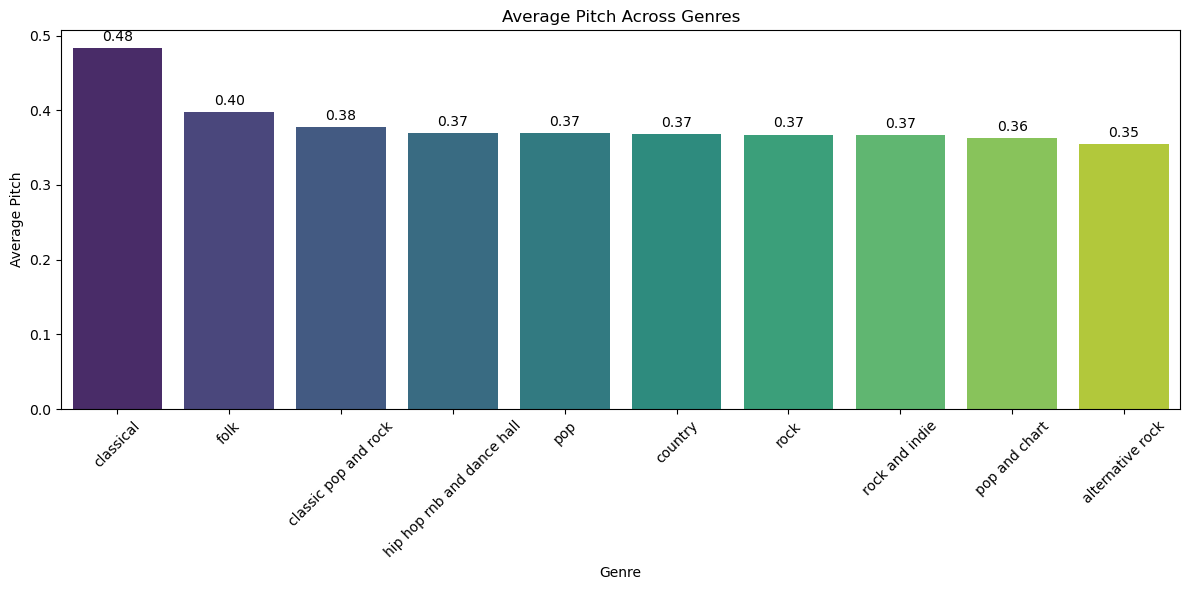

In [2286]:
# Group by Genre and calculate mean pitch
genre_pitch_means = final_filtered.groupby('Genre')['avg_pitch'].mean().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
bars = sns.barplot(x=genre_pitch_means.index, y=genre_pitch_means.values, palette="viridis")

# Add bar labels
for i, bar in enumerate(bars.patches):
    bars.annotate(format(bar.get_height(), '.2f'),
                  (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                  ha='center', va='center', size=10, xytext=(0, 8),
                  textcoords='offset points')

# Update title and labels to match the data being plotted
plt.title("Average Pitch Across Genres")
plt.xlabel("Genre")
plt.ylabel("Average Pitch")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/w9/x_vp270x1kjf9vjzyjp15q5h0000gp/T/ipykernel_68179/1256960132.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=genre_key_changes_means.index, y=genre_key_changes_means.values, palette="pink")


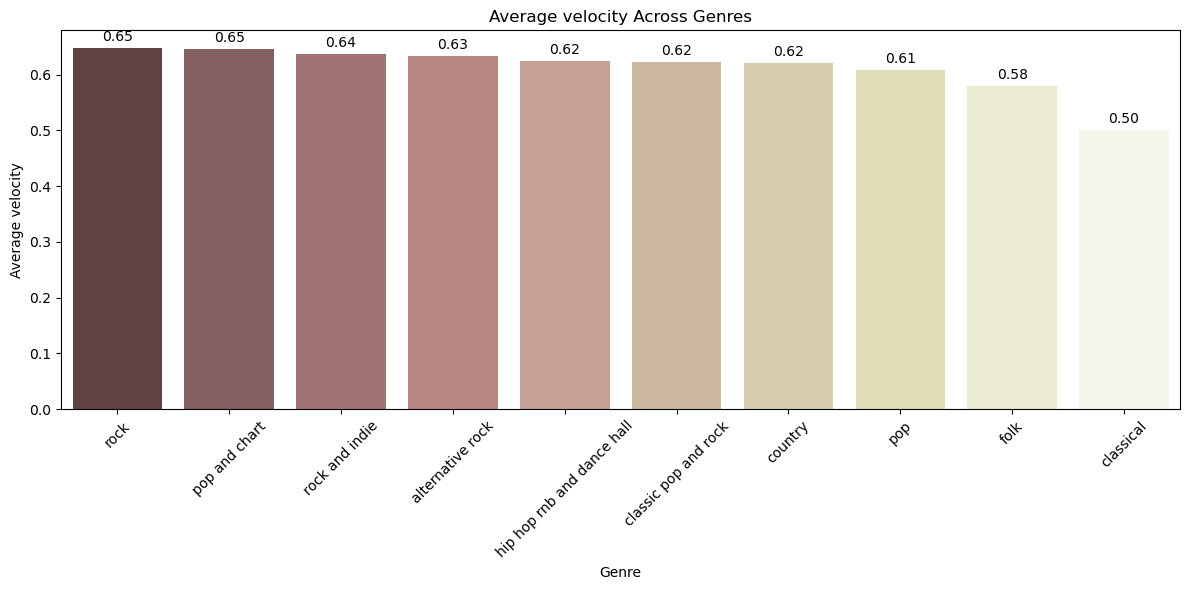

In [2287]:
# Group by Genre and calculate mean key changes
genre_key_changes_means = final_filtered.groupby('Genre')['avg_velocity'].mean().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
bars = sns.barplot(x=genre_key_changes_means.index, y=genre_key_changes_means.values, palette="pink")

# Add bar labels
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.2f'),
                  (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                  ha='center', va='center', size=10, xytext=(0, 8),
                  textcoords='offset points')

# Set plot titles and labels
plt.title("Average velocity Across Genres")
plt.xlabel("Genre")
plt.ylabel("Average velocity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
